# Fixed and Random Effect Models: Identifying Relationships of Individuals Within and Between Groups 
#### by [J. Nathan Matias](https://twitter.com/natematias),  April 21, 2015

*THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.*

## About Random Effects Models
In random effects models, we are fitting a model that includes [panel data](http://en.wikipedia.org/wiki/Panel_data), either multiple observations for an individual, or multiple observations like a group. 

Why do we use a different approach in this case? Groups and individuals are great examples of cases where the linear regression assumption of "*independence of observations*" does not apply. Imagine if we have observations of students from several schools. Observations of students*(level 1)* are not all independent from each other; we can assume that some of the variation in the observations comes from unobserved variables that students share within the same school, and that school experiences differ from each other at the group level*(level 2)* in ways that aren't observed in our dataset. Multilevel models allow us to account for the variation between individuals and also the variation between groups.

Another use of Multilevel models is to model change, where we have observations from many individuals over time and we want to identify change over time. The individual observed events are grouped by the person in question.

*For the Bayesian approach to multilevel methods, [Chris Fonnesbeck](http://biostat.mc.vanderbilt.edu/wiki/Main/ChrisFonnesbeck), assistant prof of biostatistics at Vanderbilt, has published a notebook showing how to do [Bayesian multilevel modeling with pymc](http://nbviewer.ipython.org/github/fonnesbeck/multilevel_modeling/blob/master/multilevel_modeling.ipynb).*

## Dataset
The dataset used here is a classic pedagogical dataset, from the [High School and Beyond study](https://nces.ed.gov/surveys/hsb/) by the National Center for Education Statistics, which followed high school students starting in 1980, continuing through 1982, 1984, 1986, and 1992. [The High School and Beyond study has its own wikipedia page](http://en.wikipedia.org/wiki/High_School_and_Beyond), which includes 48 published studies based on the data.

## Research Question: Do Catholic Schools and Students in Catholic Schools have Different Math Achievement from Public Schools, when Controlling For SES?
This example is drawn from the work of Andrew Ho and John Willett, from class examples in the [S-052 class](http://my.gse.harvard.edu/course/gse-s052) at the Harvard Graduate School of Education. It also roughly follows the course of Chapters 3 and 4 of Singer, Judith D., Willett, John B. (2003) [Applied Longitudinal Data Analysis: Modeling Change and Event Occurrence](http://www.ats.ucla.edu/stat/examples/alda.htm). Oxford University Press. 

**important note**: *However, the [MixedLM library](http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.mixed_linear_model.MixedLM.html) in statsmodels is relatively recent, so many of the methods outlined by the above authors are not yet possible in Python, notably analysis of variance components of the models and intra-class correlation. There is a Google Summer of Code proposal for 2015 to [add variance components to MixedLM](https://github.com/statsmodels/statsmodels/wiki/GSoC-2015-Proposal:-Improvements-to-Mixed-Effects-Models) , but the announcement was 5 days away when I published this, so we shall have to see. Let's hope it works out. The approach taken here is the likelihood-based approach. Statsmodels [MixedLM can also be used with a Generalized Estimating Equation (GEE) approach](http://nbviewer.ipython.org/urls/umich.box.com/shared/static/lc6uf6dmabmitjbup3yt.ipynb).

In this study, we want to know if catholic schools and public schools (and individual students in those schools) differ in their math achievement, when controlling for SES. In order to answer this question, we turn to a random effects model, which assumes that:
* the basic assumptions of linear regression
* the individual residuals (error) are normally distributed in the population
* the group residuals (error) are normally distributed in the population

It's this final assumption that when satisfied allows us to make claims about the population of groups, and not just the groups represented in this dataset. The population model for a random effects model is:

$$y_{ij} = \beta_{0} + \beta_{1}X_{ij} + u_{j} + \epsilon_{ij}$$
$$u_{j} \space \widetilde\space \space i.i.d.   N(0, \sigma^{2}_{u})$$
$$\epsilon_{ij} \space \widetilde\space \space i.i.d.   N(0, \sigma^{2}_{\epsilon})$$

In [97]:
# THINGS TO IMPORT
# This is a baseline set of libraries I import by default if I'm rushed for time.
%matplotlib inline
import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy
from patsy import dmatrices

In [2]:
# High School and Beyond Dataset
# https://nces.ed.gov/surveys/hsb/

import urllib2
import os.path
if(os.path.isfile("hsb.dta")!=True):
    response = urllib2.urlopen("http://www.stata-press.com/data/mlmus3/hsb.dta")
    if(response.getcode()==200):
        f = open("hsb.dta","w")
        f.write(response.read())
        f.close()
hsb_df = pd.read_stata("hsb.dta")
print hsb_df[['mathach','ses']].describe()
print 
print "CROSSTAB"
print pd.crosstab(hsb_df['sector'], [hsb_df['female'],hsb_df['minority']])

           mathach          ses
count  7185.000000  7185.000000
mean     12.747853     0.000143
std       6.878246     0.779355
min      -2.832000    -3.758000
25%       7.275000    -0.538000
50%      13.131000     0.002000
75%      18.316999     0.602000
max      24.993000     2.692000

CROSSTAB
female       0          1     
minority     0    1     0    1
sector                        
0         1315  415  1406  506
1         1166  494  1324  559


# Exploring Within-Group Variation and Between-Group Variation
Multilevel models make sense inc ases where we might expect there to be variation between groups (*or in the time case, variation/differences between individuals*).

* *Within group variation*: the amount of variation attributable to individuals within a group
* *Between group variation*: the amount of variation attributable between groups

One way to explore within and between group variation is to do boxplots of the outcome by group. When looking at the first plot, we try to gain an intuitive sense of how much the outcome varies by group and how much it varies within groups. In this case, it's not obvious that there are many differences between groups, since so many of the error bars overlap, so we'll have to find another way to assert that difference.

In the second plot, we show the de-meaned math achievement, which allows us to look at the variation within schools, next to each other.
> *Note that the Pandas boxplot method only shows us the median line, which is why there's some jitter in the second plot. (Matplotlib apparently allows us to specify the mean with meanline=True, but I couldn't get the argument to pass through from Pandas.)*

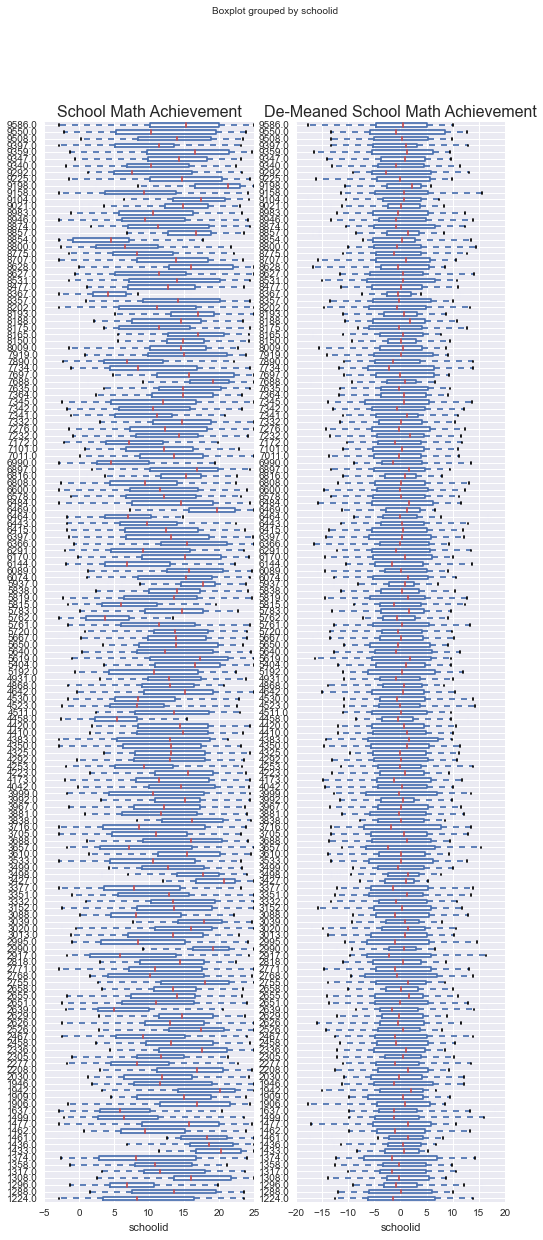

In [21]:
#generate de-meaned mathach
sgp = school_gp.to_dict()
def school_mathach(f):
    return float(f.mathach) - sgp['mathach'][f.schoolid]

hsb_df['school_mathach'] = hsb_df.apply(school_mathach, 1)

#make the Side-by-Side Boxplot
fig = plt.figure(num=None, figsize=(8, 20), dpi=80, edgecolor='k')
ax = fig.add_subplot(121)
hsb_df.boxplot("mathach", by="schoolid", ax=ax, vert=False)
plt.title("School Math Achievement", fontsize="16")

ax2 = fig.add_subplot(122)
hsb_df.boxplot("school_mathach", by="schoolid", ax=ax2, vert=False)
plt.title("De-Meaned School Math Achievement", fontsize="16")
plt.show()

# Predicting Math Achievement from SES with Linear Models
Another way to look at the group variation, let's compare two basic linear models, one of individual students, one with school means. In the following linear models, we see that there is there is indeed a relationship between SES and math achivement **between school mean math achievement**. However, just as the student-level model doesn't explain the group-level variation between schools, the school-level model doesn't explain the individual-level variation within schools. This is especially evident at high and low levels of SES or math achievement, where the group level model doesn't extend.

MODEL 1: Regressing Student Math Achievement on Student SES
                            OLS Regression Results                            
Dep. Variable:                mathach   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     1075.
Date:                Wed, 22 Apr 2015   Prob (F-statistic):          8.71e-220
Time:                        08:18:02   Log-Likelihood:                -23549.
No. Observations:                7185   AIC:                         4.710e+04
Df Residuals:                    7183   BIC:                         4.712e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------

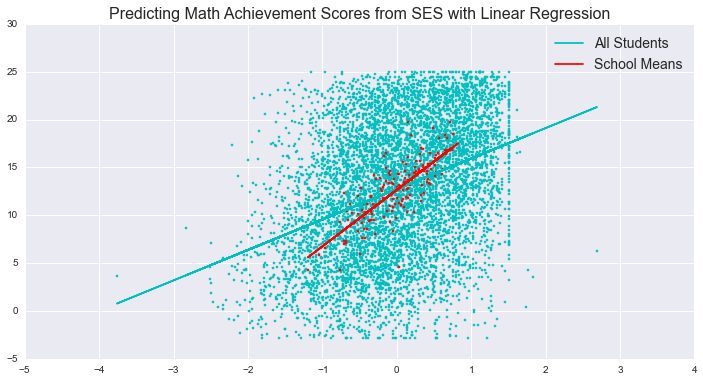

In [3]:
result = smf.ols(formula = "mathach ~ ses", 
                 data = hsb_df).fit()
print "==========================================================="
print "MODEL 1: Regressing Student Math Achievement on Student SES"
print result.summary()
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(hsb_df.ses, hsb_df.mathach, marker=".", color="c")
student_line, = plt.plot(hsb_df['ses'], result.predict(), "-", color="c")
#plt.title("Predicting Math Achievement from SES Across all 7185 students", fontsize="16")

school_gp = hsb_df.groupby("schoolid").aggregate(np.mean)
result = smf.ols(formula = "mathach ~ ses", 
                 data = school_gp).fit()
print
print "==================================================================="
print "MODEL 2: Regressing Mean School Math Achievement on Mean School SES"  
print result.summary()
#plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(school_gp.ses, school_gp.mathach, marker=".", color="r")
school_line, = plt.plot(school_gp.ses, result.predict(), "-", color="r")
plt.title("Predicting Math Achievement Scores from SES with Linear Regression", fontsize="16")

plt.legend([student_line, school_line], ['All Students', 'School Means'], fontsize="14")
plt.show()

# Variance Components and Intraclass Correlation
Sadly, statsmodels does not offer us tools for considering things like within and between group variance or intraclass correlation. This makes it difficult to do things like calculate the Durbin-Wu

# Fixed Effect Model: Predicting Math Achievement with De-Meaned SES
In the fixed effects model, we add $u_{j}$ to the model, denoting the group level variance, absorbing all the variance between groups in order to better estimate the variance within groups. 

$$y_{ij} = \beta_{0} + \beta_{1}X_{ij} + \mathbf{u_{j}} + \epsilon_{ij}$$
$$\epsilon_{ij} \space \widetilde\space \space i.i.d.   N(0, \sigma^{2}_{\epsilon})$$

In practice, we can do this in several equivalent ways. I show two here:
* add the school mean SES as a predictor to the model
* replace SES with the "de-meaned" SES rather than the SES as our predictor. In the de-meaned model, instead of using the SES of the individual in the school, we are using amount by which that student differs from the mean SES in the school.

In both cases, we effectively remove the variation between groups from the model. The resulting SES or demeaned_ses predictor models the within-school variation between students.

In the following models, notice how the slope for *ses* is the same as the slope for *demeaned_ses* in the two models.

In [31]:
# calculate the demeaned_ses for each student
def demeaned_ses(f):
    return f.ses - school_gp.to_dict()['ses'][f['schoolid']]
# add the school mean SES to the dataframe for each student
def schoolmean_ses(f):
    return school_gp.to_dict()['ses'][f['schoolid']]
hsb_df['demeaned_ses'] = hsb_df.apply(demeaned_ses, axis=1)
hsb_df['schoolmean_ses'] = hsb_df.apply(schoolmean_ses, axis=1)


MODEL: Regressing Student Math Achievement on De-meaned Student SES
Intercept         12.747033
ses                2.191172
schoolmean_ses     3.525709
dtype: float64

MODEL: Regressing Student Math Achievement on De-meaned Student SES
Intercept       12.747853
demeaned_ses     2.191172
dtype: float64

Notice how the slope for *ses* is the same as the slope for *demeaned_ses* in the two models



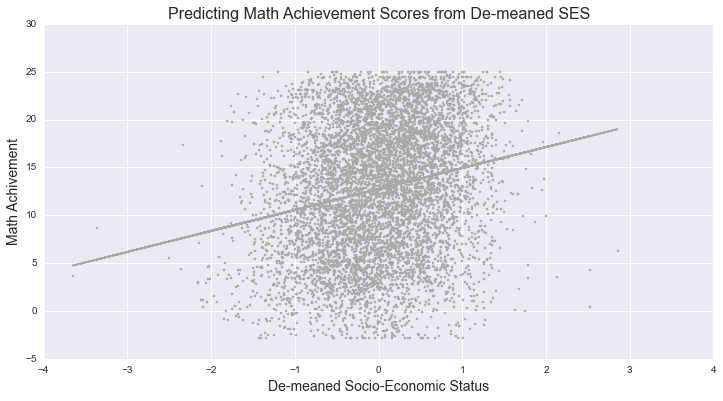

In [49]:

result_school_covary = smf.ols(formula = "mathach ~ ses + schoolmean_ses", 
                 data = hsb_df).fit()
print "MODEL: Regressing Student Math Achievement on De-meaned Student SES"
print result_school_covary.params

result = smf.ols(formula = "mathach ~ demeaned_ses", 
                 data = hsb_df).fit()
print
print "MODEL: Regressing Student Math Achievement on De-meaned Student SES"
print result.params
print
print "Notice how the slope for *ses* is the same as the slope for *demeaned_ses* in the two models"
print

plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(hsb_df.demeaned_ses, hsb_df.mathach, marker=".", color="darkgrey")
student_line, = plt.plot(hsb_df['demeaned_ses'], result.predict(), "-", color="darkgrey")
plt.title("Predicting Math Achievement Scores from De-meaned SES", fontsize="16")
plt.xlabel("De-meaned Socio-Economic Status", fontsize="14")
plt.ylabel("Math Achivement", fontsize="14")
plt.show()

## Plotting the Fixed Effects Model for Individual Schools
We can plot the fixed effects model on a school-level basis using the model that uses the school mean as a covariate and then plotting the model for prototypical values of individual schools.

It's important to note however that this model makes no claims about the population of all schools -- it just models the relationship between student math achievement and student SES, holding constant the variation in SES between schools.

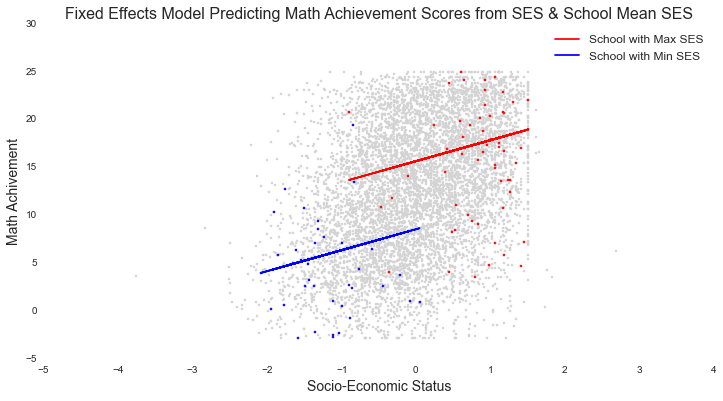

In [240]:
# highlight the maximum, and minimum 
max_school = school_gp[school_gp['ses'] == school_gp.ses.max()].index[0]
min_school = school_gp[school_gp['ses'] == school_gp.ses.min()].index[0]

hsb_df['fixed_preds'] = result_school_covary.predict()

plt.figure(num=None, figsize=(12, 6), dpi=80, edgecolor='k')
for schoolid in hsb_df.schoolid.unique():
    if(schoolid!=max_school and schoolid!=min_school):
        plt.scatter(hsb_df[hsb_df.schoolid == schoolid].ses, hsb_df[hsb_df.schoolid == schoolid].mathach, marker=".", color="lightgrey")         

for schoolid in hsb_df.schoolid.unique():
    if(schoolid == max_school):
        plt.scatter(hsb_df[hsb_df.schoolid == schoolid].ses, hsb_df[hsb_df.schoolid == schoolid].mathach, marker=".", color="r") 
        maxline, = plt.plot(hsb_df[hsb_df.schoolid == schoolid].ses, hsb_df[hsb_df.schoolid == schoolid].fixed_preds, "-", color="r")
    elif(schoolid == min_school):
        plt.scatter(hsb_df[hsb_df.schoolid == schoolid].ses, hsb_df[hsb_df.schoolid == schoolid].mathach, marker=".", color="b") 
        minline, = plt.plot(hsb_df[hsb_df.schoolid == schoolid].ses, hsb_df[hsb_df.schoolid == schoolid].fixed_preds, "-", color="b")
plt.legend([maxline, minline], ['School with Max SES', 'School with Min SES'], fontsize="12")

plt.title("Fixed Effects Model Predicting Math Achievement Scores from SES & School Mean SES", fontsize="16")
plt.xlabel("Socio-Economic Status", fontsize="14")
plt.ylabel("Math Achivement", fontsize="14")
plt.show()

# Random Effects Model
A random effects model makes the assumption that the variance attributable to groups is normal in the population (and centered on 0), allowing us to make claims about groups, and not just individual observations. In the school example, this would allow us to make claims about schools as well as the individuals within them. In a timeseries example, this is equally important, because it's only in the random effects world that we would be able to make claims about the population of things that we're observing over time. Correspondingly, our population model for the random effects model, although it has the same terms of the fixed effects model, has an additional assumption about $u_{j}$:

$$y_{ij} = \beta_{0} + \beta_{1}X_{ij} + u_{j} + \epsilon_{ij}$$
$$\mathbf{u_{j} \space \widetilde\space \space i.i.d.   N(0, \sigma^{2}_{u})}$$
$$\epsilon_{ij} \space \widetilde\space \space i.i.d.   N(0, \sigma^{2}_{\epsilon})$$

In [289]:
##http://statsmodels.sourceforge.net/devel/mixed_linear.html
md = smf.mixedlm("mathach ~ ses", data=hsb_df, groups=hsb_df["schoolid"])
result = md.fit()
print result.summary()

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mathach    
No. Observations: 7185    Method:             REML       
No. Groups:       160     Scale:              37.0344    
Min. group size:  14      Likelihood:         -23322.5847
Max. group size:  67      Converged:          Yes        
Mean group size:  44.9                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      12.657    0.188 67.322 0.000 12.288 13.025
ses             2.390    0.108 22.133 0.000  2.179  2.602
Intercept RE    4.768    0.109                           



In the above results, the *ses* coefficient of 2.390 is:
* the slope of the relationship between math achievement and ses among the population of students within a school
* also the slope of the relationship between math achievement and ses among the population of schools (In a timeseries situation, this becomes especially meaningful in cases where we add further covariates that explain differences between individuals over time)

# Comparing Linear, Grouped, De-Meaned, and Mixed Effects Models
For fun, here is a plot that shows all of the models that we have fit so far on the same plot.

MODEL 1: Regressing Student Math Achievement on Student SES
                            OLS Regression Results                            
Dep. Variable:                mathach   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     253.1
Date:                Wed, 22 Apr 2015   Prob (F-statistic):           1.25e-34
Time:                        15:58:18   Log-Likelihood:                -331.96
No. Observations:                 160   AIC:                             667.9
Df Residuals:                     158   BIC:                             674.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------

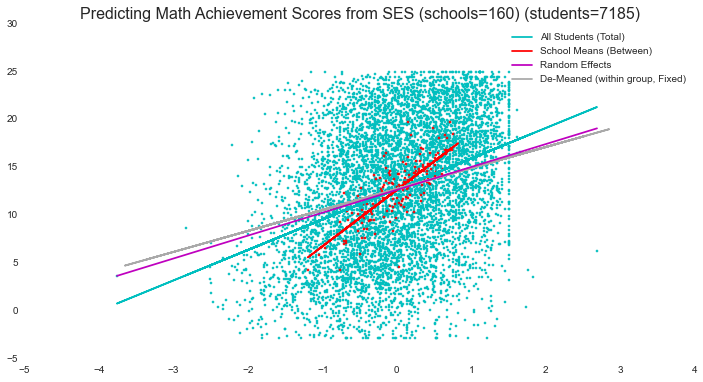

In [298]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

result = smf.ols(formula = "mathach ~ ses", 
                 data = hsb_df).fit()
print "MODEL 1: Regressing Student Math Achievement on Student SES"
plt.scatter(hsb_df.ses, hsb_df.mathach, marker=".", color="c")
student_line, = plt.plot(hsb_df['ses'], result.predict(), "-", color="c")

school_gp = hsb_df.groupby("schoolid").aggregate(np.mean)
result = smf.ols(formula = "mathach ~ ses", 
                 data = school_gp).fit()
print result.summary()

print 
print "MODEL 2: Regressing Mean School Math Achievement on Mean School SES"  
print result.summary()
#plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(school_gp.ses, school_gp.mathach, marker=".", color="r")
school_line, = plt.plot(school_gp.ses, result.predict(), "-", color="r")

result = smf.ols(formula = "mathach ~ demeaned_ses", 
                 data = hsb_df).fit()
print "MODEL 3: Regressing Student Math Achievement on De-meaned Student SES"
print result.summary()
#plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
demeaned_line, = plt.plot(hsb_df['demeaned_ses'], result.predict(), "-", color="darkgrey")

print
print "MODEL 4: Regressing Student Math Achievement on Student SES Grouped by School in a Random Effects Model"  

md = smf.mixedlm("mathach ~ ses", data=hsb_df, groups=hsb_df["schoolid"])
result = md.fit()
print result.summary()

def predict(x, key, result):
    return result.params.Intercept + result.params['ses']*x
ses = np.linspace(hsb_df.ses.min(), hsb_df.ses.max(), 100)
preds = [predict(x, 'ses',result) for x in ses]
multi_line, = plt.plot(ses, preds, "-", color="m")

plt.title("Predicting Math Achievement Scores from SES (schools=160) (students=7185)", fontsize="16")
plt.legend([student_line, school_line, multi_line, demeaned_line], ['All Students (Total)', 'School Means (Between)', "Random Effects", "De-Meaned (within group, Fixed)"])
plt.show()

#Calculate Within Group Variance, Between Group Variance, and Intraclass Correlation of a Random Effects Models
In a random effects model, The **intraclass correlation** can be interpreted as:
* the group variation as a proportion of total variance
* the proportion of overall variation in math scores "accounted for by" the group

Intraclass correlation is apparently still being debated, as outlined in [the Wikipedia page for intraclass correlation](http://en.wikipedia.org/wiki/Intraclass_correlation), and some people avoid this measure entirely.

The statsmodels MixedLM model doesn't include within it any analysis of residuals, so of we want to consider the intraclass correlation in the model, we have to do it ourselves. I've written a method to collect the individual and group residuals. 

Note that I *think* the calculations presented here are correct, but I have only run them against a single test case, so you may want to doublecheck my work before lifting this code.

In [357]:
##http://statsmodels.sourceforge.net/devel/mixed_linear.html
md = smf.mixedlm("mathach ~ ses", data=hsb_df, groups=hsb_df["schoolid"])
result = md.fit()
print result.summary()

#store the model results to a variable
models = {}
m = "Model1"
models[m] = {}
models[m]['result'] = result

def individual_residuals(f):
    observed_individual = f.mathach
    predicted_individual = result.params.Intercept + result.params['ses']*f.ses
    return observed_individual - predicted_individual 

def group_residuals(f):
    observed_group = school_gp.to_dict()['mathach'][f.schoolid]
    predicted_group = result.params.Intercept + result.params['ses']*f.schoolmean_ses
    return predicted_group - observed_group

group_count = school_gp.count()[0]
indiv_count = hsb_df.count()[0]

resid_u = hsb_df.apply(group_residuals, 1)
models[m]["sigma_u"] = np.std(resid_u)
models[m]["sigma_u_err"] = models[m]["sigma_u"]/math.sqrt(group_count)

resid_e = hsb_df.apply(individual_residuals, 1)
models[m]["sigma_e"] = np.std(resid_e)
models[m]["sigma_e_err"] = models[m]["sigma_e"]/math.sqrt(indiv_count)

models[m]["icc"] = math.pow(models[m]["sigma_u"],2)/(math.pow(models[m]["sigma_u"],2) + math.pow(models[m]["sigma_e"],2))
models[m]["icc_err"] = icc/math.sqrt(group_count)

print "                                   stdev      stderr"
print "sigma_u (between group variation): %(s).04f     %(e).04f" % {'s':models[m]["sigma_u"],
                                                                    'e':models[m]["sigma_u_err"]} 
print "sigma_e (within group variation):  %(s).04f     %(e).04f" % {'s':models[m]["sigma_e"], 
                                                                    'e':models[m]["sigma_e_err"]} 
print "intraclass correlation:            %(i).04f     %(e).04f" % {'i':models[m]["icc"], 
                                                                    'e':models[m]["icc_err"]}
print
print "Z-Test of intraclass correlation:"
print "  H0:             icc = 0 in the population"
print "  test-statistic: z=icc/SE(icc)"
print "  decision rule:  z>z_crit"
print "  critical value: 1.96"
print "  z = %(z).04f" %{'z':models[m]["icc"] /models[m]["icc_err"]}

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mathach    
No. Observations: 7185    Method:             REML       
No. Groups:       160     Scale:              37.0344    
Min. group size:  14      Likelihood:         -23322.5847
Max. group size:  67      Converged:          Yes        
Mean group size:  44.9                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      12.657    0.188 67.322 0.000 12.288 13.025
ses             2.390    0.108 22.133 0.000  2.179  2.602
Intercept RE    4.768    0.109                           

                                   stdev      stderr
sigma_u (between group variation): 2.3103     0.1826
sigma_e (within group variation):  6.4444     0.0760
intraclass correlation:            0.1139     0.0090

Z-Test of intraclass correlation:
  H0:   

In this case, we see that there is a low intraclass correlation, suggesting that most of the variation in math achievement scores is within schools, but that there is a significant difference between the math achievement of schools on average in the model as well (as indicated by the Z test).

# Using Pseudo-$R^{2}$ To Describe Changes in Variance Components
If we are interested in differences between the proportion of between-group or within group variance accounted for by competing models, we can generate a pseudo-$R^{2}$ measure by comparing the between and within group variances to those of a baseline model.

In [358]:
# now generate the baseline model
md = smf.mixedlm("mathach ~ 1", data=hsb_df, groups=hsb_df["schoolid"])
result = md.fit()
print result.summary()

def individual_residuals(f):
    observed_individual = f.mathach
    predicted_individual = result.params.Intercept
    return observed_individual - predicted_individual 

def group_residuals(f):
    observed_group = school_gp.to_dict()['mathach'][f.schoolid]
    predicted_group = result.params.Intercept
    return predicted_group - observed_group

group_count = school_gp.count()[0]
indiv_count = hsb_df.count()[0]

m = "Model0"
models[m] = {}
models[m]['result'] = result

resid_u = hsb_df.apply(group_residuals, 1)
models[m]["sigma_u"] = np.std(resid_u)
models[m]["sigma_u_err"] = models[m]["sigma_u"]/math.sqrt(group_count)

resid_e = hsb_df.apply(individual_residuals, 1)
models[m]["sigma_e"] = np.std(resid_e)
models[m]["sigma_e_err"] = models[m]["sigma_e"]/math.sqrt(indiv_count)

models[m]["icc"] = math.pow(models[m]["sigma_u"],2)/(math.pow(models[m]["sigma_u"],2) + math.pow(models[m]["sigma_e"],2))
models[m]["icc_err"] = icc/math.sqrt(group_count)

print "                                   stdev      stderr"
print "sigma_u (between group variation): %(s).04f     %(e).04f" % {'s':models[m]["sigma_u"],
                                                                    'e':models[m]["sigma_u_err"]} 
print "sigma_e (within group variation):  %(s).04f     %(e).04f" % {'s':models[m]["sigma_e"], 
                                                                    'e':models[m]["sigma_e_err"]} 
print "intraclass correlation:            %(i).04f     %(e).04f" % {'i':models[m]["icc"], 
                                                                    'e':models[m]["icc_err"]}
print
print "Z-Test of intraclass correlation:"
print "  H0:             icc = 0 in the population"
print "  test-statistic: z=icc/SE(icc)"
print "  decision rule:  z>z_crit"
print "  critical value: 1.96"
print "  z = %(z).04f" %{'z':models[m]["icc"] /models[m]["icc_err"]}

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mathach    
No. Observations: 7185    Method:             REML       
No. Groups:       160     Scale:              39.1483    
Min. group size:  14      Likelihood:         -23558.3967
Max. group size:  67      Converged:          Yes        
Mean group size:  44.9                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      12.636    0.244 51.702 0.000 12.157 13.115
Intercept RE    8.614    0.175                           

                                   stdev      stderr
sigma_u (between group variation): 3.0056     0.2376
sigma_e (within group variation):  6.8778     0.0811
intraclass correlation:            0.1603     0.0090

Z-Test of intraclass correlation:
  H0:             icc = 0 in the population
  test-statistic: z=ic

## Calculating Pseudo-$R^{2}$
To calculate pseudo-$R^{2}$, we use the following equations:

Between group variation: $R^{2}_{u} = \sigma_{u,0}^{2} -  \sigma_{u,1}^{2}/\sigma_{u,0}^{2}$

Within group variation: $R^{2}_{e} = \sigma_{e,0}^{2} -  \sigma_{e,1}^{2}/\sigma_{e,0}^{2}$

In [359]:
m0 = "Model0"
m1 = "Model1"
r2_u = math.pow(models[m0]['sigma_u'], 2) - math.pow(models[m1]['sigma_u'], 2)/math.pow(models[m0]['sigma_u'], 2)
print "Pseudo R^2 for group variation: %(r).03f%%" % {'r':r2_u} 
r2_e = math.pow(models[m0]['sigma_e'], 2) - math.pow(models[m1]['sigma_e'], 2)/math.pow(models[m0]['sigma_e'], 2)
print "Pseudo R^2 for individual variation: %(r).03f%%" % {'r':r2_e} 

Pseudo R^2 for group variation: 8.443%
Pseudo R^2 for individual variation: 46.426%


In the above pseudo $R^{2}$ calculations, we see that our model of math achievement on SES accounts for 8.44% of the between-group variation and 46.43% of the within-group variation. This is consistent with our intraclass correlation, which shows that in the model there is much more within-group variation than betwen-group variation.

# Level Two Predictors: Testing Our Hypothesis About Catholic Schools
At the beginning of this example, we asked if  Catholic Schools and Students in Catholic Schools have different Math Achievement from Public Schools, when Controlling For SES? To answer this question, we add another predictor, a "level-2," group-level predictor that contains information about schools rather than individual students.

In [360]:
# in this dataset, sector refers to whether the school is catholic(1) or public(0)
from patsy import dmatrices
md = smf.mixedlm("mathach ~ ses + sector", data=hsb_df, groups=hsb_df["schoolid"])
result = md.fit()
print result.summary()

def individual_residuals(f):
    observed_individual = f.mathach
    predicted_individual = result.params.Intercept + result.params['ses']*f.ses + result.params['sector']*f.sector
    return observed_individual - predicted_individual 

def group_residuals(f):
    observed_group = school_gp.to_dict()['mathach'][f.schoolid]
    predicted_group = result.params.Intercept + result.params['ses']*f.schoolmean_ses + result.params['sector']*f.sector
    return predicted_group - observed_group

group_count = school_gp.count()[0]
indiv_count = hsb_df.count()[0]

m = "Model2"
models[m] = {}
models[m]['result'] = result

resid_u = hsb_df.apply(group_residuals, 1)
models[m]["sigma_u"] = np.std(resid_u)
models[m]["sigma_u_err"] = models[m]["sigma_u"]/math.sqrt(group_count)

resid_e = hsb_df.apply(individual_residuals, 1)
models[m]["sigma_e"] = np.std(resid_e)
models[m]["sigma_e_err"] = models[m]["sigma_e"]/math.sqrt(indiv_count)

models[m]["icc"] = math.pow(models[m]["sigma_u"],2)/(math.pow(models[m]["sigma_u"],2) + math.pow(models[m]["sigma_e"],2))
models[m]["icc_err"] = icc/math.sqrt(group_count)

print "                                   stdev      stderr"
print "sigma_u (between group variation): %(s).04f     %(e).04f" % {'s':models[m]["sigma_u"],
                                                                    'e':models[m]["sigma_u_err"]} 
print "sigma_e (within group variation):  %(s).04f     %(e).04f" % {'s':models[m]["sigma_e"], 
                                                                    'e':models[m]["sigma_e_err"]} 
print "intraclass correlation:            %(i).04f     %(e).04f" % {'i':models[m]["icc"], 
                                                                    'e':models[m]["icc_err"]}
print
print "Z-Test of intraclass correlation:"
print "  H0:             icc = 0 in the population"
print "  test-statistic: z=icc/SE(icc)"
print "  decision rule:  z>z_crit"
print "  critical value: 1.96"
print "  z = %(z).04f" %{'z':models[m]["icc"] /models[m]["icc_err"]}

print
m0 = "Model0"
m1 = "Model2"
r2_u = math.pow(models[m0]['sigma_u'], 2) - math.pow(models[m1]['sigma_u'], 2)/math.pow(models[m0]['sigma_u'], 2)
print "Pseudo R^2 for group variation: %(r).03f%%" % {'r':r2_u} 
r2_e = math.pow(models[m0]['sigma_e'], 2) - math.pow(models[m1]['sigma_e'], 2)/math.pow(models[m0]['sigma_e'], 2)
print "Pseudo R^2 for individual variation: %(r).03f%%" % {'r':r2_e} 

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mathach    
No. Observations: 7185    Method:             REML       
No. Groups:       160     Scale:              37.0369    
Min. group size:  14      Likelihood:         -23305.5755
Max. group size:  67      Converged:          Yes        
Mean group size:  44.9                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      11.718    0.228 51.375 0.000 11.271 12.165
ses             2.375    0.107 22.103 0.000  2.164  2.585
sector          2.101    0.341  6.159 0.000  1.432  2.770
Intercept RE    3.685    0.089                           

                                   stdev      stderr
sigma_u (between group variation): 2.0611     0.1629
sigma_e (within group variation):  6.3591     0.0750
intraclass correlation:            0.0

###Now add an interaction between sector and SES

In [361]:
# in this dataset, sector refers to whether the school is catholic(1) or public(0)
from patsy import dmatrices
md = smf.mixedlm("mathach ~ ses + sector + sector:ses", data=hsb_df, groups=hsb_df["schoolid"])
result = md.fit()
print result.summary()

def individual_residuals(f):
    observed_individual = f.mathach
    predicted_individual = result.params.Intercept + result.params['ses']*f.ses + result.params['sector']*f.sector + result.params['sector:ses']*f.sector*f.ses 
    return observed_individual - predicted_individual 

def group_residuals(f):
    observed_group = school_gp.to_dict()['mathach'][f.schoolid]
    predicted_group = result.params.Intercept + result.params['ses']*f.schoolmean_ses + result.params['sector']*f.sector + result.params['sector:ses']*f.sector*f.ses
    return predicted_group - observed_group

group_count = school_gp.count()[0]
indiv_count = hsb_df.count()[0]

m = "Model3"
models[m] = {}
models[m]['result'] = result

resid_u = hsb_df.apply(group_residuals, 1)
models[m]["sigma_u"] = np.std(resid_u)
models[m]["sigma_u_err"] = models[m]["sigma_u"]/math.sqrt(group_count)

resid_e = hsb_df.apply(individual_residuals, 1)
models[m]["sigma_e"] = np.std(resid_e)
models[m]["sigma_e_err"] = models[m]["sigma_e"]/math.sqrt(indiv_count)

models[m]["icc"] = math.pow(models[m]["sigma_u"],2)/(math.pow(models[m]["sigma_u"],2) + math.pow(models[m]["sigma_e"],2))
models[m]["icc_err"] = icc/math.sqrt(group_count)

print "                                   stdev      stderr"
print "sigma_u (between group variation): %(s).04f     %(e).04f" % {'s':models[m]["sigma_u"],
                                                                    'e':models[m]["sigma_u_err"]} 
print "sigma_e (within group variation):  %(s).04f     %(e).04f" % {'s':models[m]["sigma_e"], 
                                                                    'e':models[m]["sigma_e_err"]} 
print "intraclass correlation:            %(i).04f     %(e).04f" % {'i':models[m]["icc"], 
                                                                    'e':models[m]["icc_err"]}
print
print "Z-Test of intraclass correlation:"
print "  H0:             icc = 0 in the population"
print "  test-statistic: z=icc/SE(icc)"
print "  decision rule:  z>z_crit"
print "  critical value: 1.96"
print "  z = %(z).04f" %{'z':models[m]["icc"] /models[m]["icc_err"]}

print
m0 = "Model0"
m1 = "Model3"
r2_u = math.pow(models[m0]['sigma_u'], 2) - math.pow(models[m1]['sigma_u'], 2)/math.pow(models[m0]['sigma_u'], 2)
print "Pseudo R^2 for group variation: %(r).02f%%" % {'r':r2_u} 
r2_e = math.pow(models[m0]['sigma_e'], 2) - math.pow(models[m1]['sigma_e'], 2)/math.pow(models[m0]['sigma_e'], 2)
print "Pseudo R^2 for individual variation: %(r).02f%%" % {'r':r2_e} 

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mathach    
No. Observations: 7185    Method:             REML       
No. Groups:       160     Scale:              36.8403    
Min. group size:  14      Likelihood:         -23287.0822
Max. group size:  67      Converged:          Yes        
Mean group size:  44.9                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      11.800    0.229 51.634 0.000 11.352 12.247
ses             2.952    0.142 20.817 0.000  2.674  3.230
sector          2.138    0.341  6.262 0.000  1.469  2.807
sector:ses     -1.315    0.212 -6.200 0.000 -1.730 -0.899
Intercept RE    3.694    0.089                           

                                   stdev      stderr
sigma_u (between group variation): 2.1501     0.1700
sigma_e (within group variation):

# Plotting the Random Effects Model with a Level 2 Interaction
## Showing Predictions of Students in Prototypical Schools

schoolid
1946        0.004051
Name: ses, dtype: float32
schoolid
5650        0.022444
Name: ses, dtype: float32


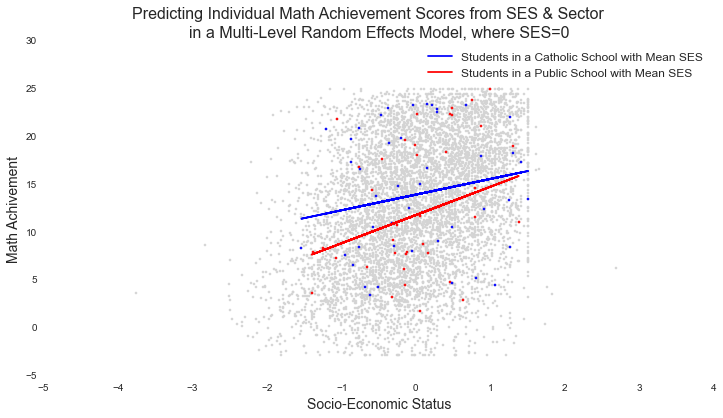

In [400]:
#step one: find prototypical values of a catholic and a public school with an SES of 0.
school_gp['p_abs_ses']=school_gp[np.isclose(school_gp.sector, 0.)].ses.map(lambda x: abs(x))
school_gp['c_abs_ses']=school_gp[np.isclose(school_gp.sector, 1.)].ses.map(lambda x: abs(x))

#public school with SES closest to 0: 1946
print school_gp[(np.isclose(school_gp.p_abs_ses,school_gp.p_abs_ses.min())) & (np.isclose(school_gp.sector, 0.))].ses
#catholic school with SES closest to 0: 5650
print school_gp[(np.isclose(school_gp.c_abs_ses,school_gp.c_abs_ses.min())) & (np.isclose(school_gp.sector, 1.))].ses
p_school = 1946
c_school = 5650

def predict(f):
    return result.params.Intercept + result.params['ses']*f.ses + result.params['sector']*f.sector + result.params['sector:ses']*f.sector*f.ses

hsb_df['interaction_preds'] = hsb_df.apply(predict, 1)

plt.figure(num=None, figsize=(12, 6), dpi=80, edgecolor='k')
# PLOT A PREDICTION OF INDIVIDUAL MATH ACHIEVEMENT SCORES
# FOR TWO SCHOOLS
for schoolid in hsb_df.schoolid.unique():
    if(schoolid!=max_school and schoolid!=min_school):
        plt.scatter(hsb_df[hsb_df.schoolid == schoolid].ses, hsb_df[hsb_df.schoolid == schoolid].mathach, marker=".", color="lightgrey")         
            
for schoolid in hsb_df.schoolid.unique():
    if(schoolid == p_school):
        plt.scatter(hsb_df[hsb_df.schoolid == schoolid].ses, hsb_df[hsb_df.schoolid == schoolid].mathach, marker=".", color="r") 
        p_line, = plt.plot(hsb_df[hsb_df.schoolid == schoolid].ses, hsb_df[hsb_df.schoolid == schoolid].interaction_preds, "-", color="r")
    elif(schoolid == c_school):
        plt.scatter(hsb_df[hsb_df.schoolid == schoolid].ses, hsb_df[hsb_df.schoolid == schoolid].mathach, marker=".", color="b") 
        c_line, = plt.plot(hsb_df[hsb_df.schoolid == schoolid].ses, hsb_df[hsb_df.schoolid == schoolid].interaction_preds, "-", color="b")
plt.legend([c_line, p_line], ['Students in a Catholic School with Mean SES', 'Students in a Public School with Mean SES'], fontsize="12")



plt.suptitle("Predicting Individual Math Achievement Scores from SES & Sector", fontsize="16")
plt.title("in a Multi-Level Random Effects Model, where SES=0", fontsize="16")

plt.xlabel("Socio-Economic Status", fontsize="14")
plt.ylabel("Math Achivement", fontsize="14")
plt.show()


## Plot Predictions for Catholic and Public Schools

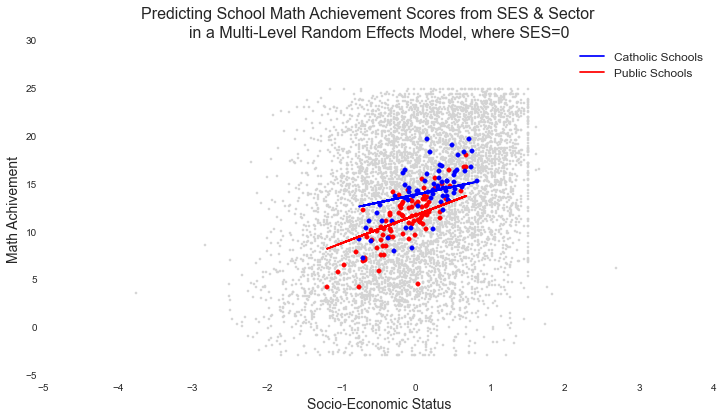

In [402]:
# PLOT SCHOOL MEAN CATHOLIC AND PUBLIC SCHOOL MATH ACHIEVEMENT
plt.figure(num=None, figsize=(12, 6), dpi=80, edgecolor='k')
plt.scatter(hsb_df.ses, hsb_df.mathach, marker=".", color="lightgrey")  
plt.scatter(school_gp[school_gp.sector==0.].ses, school_gp[school_gp.sector==0.].mathach, color="r")         
plt.scatter(school_gp[school_gp.sector==1.].ses, school_gp[school_gp.sector==1.].mathach, color="b")         

school_gp['interaction_preds'] = school_gp.apply(predict, 1)
c_line, = plt.plot(school_gp[np.isclose(school_gp.sector, 1.)].ses, school_gp[np.isclose(school_gp.sector, 1.)].interaction_preds, "-", color="b")
p_line, = plt.plot(school_gp[np.isclose(school_gp.sector, 0.)].ses, school_gp[np.isclose(school_gp.sector, 0.)].interaction_preds, "-", color="r")
plt.suptitle("Predicting School Math Achievement Scores from SES & Sector", fontsize="16")
plt.title("in a Multi-Level Random Effects Model, where SES=0", fontsize="16")
plt.legend([c_line, p_line], ['Catholic Schools', 'Public Schools'], fontsize="12")

plt.xlabel("Socio-Economic Status", fontsize="14")
plt.ylabel("Math Achivement", fontsize="14")
plt.show()

